In [46]:
import xarray as xr
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
import torch.utils.data as data
import torch.nn as nn
import glob

# from torchsummary import summary
# from torchinfo import summary
from tqdm import trange

In [47]:
device = torch.device("cuda:1")
print(device)
current_device = device  # torch.cuda.current_device()
device_name = torch.cuda.get_device_name(current_device)
print(f"Current GPU assigned: {current_device}, Name: {device_name}")

cuda:1
Current GPU assigned: cuda:1, Name: Quadro RTX 5000


In [48]:
data120 = xr.open_dataset("/home/rishabh.mondal/archive/camx120hr_merged_20230717.nc")
data96 = xr.open_dataset(
    "/home/rishabh.mondal/archive/camxmet2d.delhi.20230717.96hours.nc"
)

In [49]:
def get_latitudes():
    lat_start = 76.8499984741211
    lat_step = 0.009999999776482582

    latitudes = []

    for i in range(80):
        latitudes.append(lat_start + i * lat_step)

    latitudes.reverse()

    return latitudes


def get_longitudes():
    long_start = 28.200000762939453
    long_step = 0.009999999776482582

    longitudes = []

    for i in range(80):
        longitudes.append(long_start + i * long_step)

    # longitudes.reverse()

    return longitudes


latitudes = get_latitudes()
longitudes = get_longitudes()


def create_plot(data, hour, var_name):
    # print(data[var_name].shape) #shape (120, 1, 80, 80)
    p10_hour = data[var_name]["TSTEP" == hour]  # shape (1, 80, 80)
    p10_hour = p10_hour[0, :, :]  # shape (80, 80)
    plt.imshow(p10_hour)
    plt.title(f"{var_name} at hour " + str(hour))
    # plt.colorbar()

    # only show every latitude and longitude of end points
    # round to 2 decimal places
    top = latitudes[0]
    top = round(top, 2)
    bottom = latitudes[-1]
    bottom = round(bottom, 2)
    left = longitudes[0]
    left = round(left, 2)
    right = longitudes[-1]
    right = round(right, 2)

    plt.xticks([0, 79], [left, right])
    plt.xlabel("Longitude")
    plt.yticks([0, 79], [top, bottom])
    plt.ylabel("Latitude")

In [50]:
device = torch.device("cuda:1")

In [51]:
data120
data96

<xarray.Dataset>
Dimensions:     (TSTEP: 96, VAR: 14, DATE-TIME: 2, LAY: 1, ROW: 80, COL: 80)
Dimensions without coordinates: TSTEP, VAR, DATE-TIME, LAY, ROW, COL
Data variables: (12/15)
    TFLAG       (TSTEP, VAR, DATE-TIME) int32 ...
    TSURF_K     (TSTEP, LAY, ROW, COL) float32 ...
    SNOWEW_M    (TSTEP, LAY, ROW, COL) float32 ...
    SNOWAGE_HR  (TSTEP, LAY, ROW, COL) float32 ...
    PRATE_MMpH  (TSTEP, LAY, ROW, COL) float32 ...
    CLOUD_OD    (TSTEP, LAY, ROW, COL) float32 ...
    ...          ...
    SWSFC_WpM2  (TSTEP, LAY, ROW, COL) float32 ...
    SOLM_M3pM3  (TSTEP, LAY, ROW, COL) float32 ...
    CLDTOP_KM   (TSTEP, LAY, ROW, COL) float32 ...
    CAPE        (TSTEP, LAY, ROW, COL) float32 ...
    PBL_WRF_M   (TSTEP, LAY, ROW, COL) float32 ...
    PBL_YSU_M   (TSTEP, LAY, ROW, COL) float32 ...
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023198
    CTIME:          73941
    WDATE:          2023198
    ...             ...
    VGLVLS:         [0. 0.]
    GDNAM:          ????????????????
    UPNAM:          CAMx2IOAPI      
    VAR-LIST:       TSURF_K         SNOWEW_M        SNOWAGE_HR      PRATE_MMp...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:

In [52]:
data96_df = data96.to_dataframe().reset_index()
data96_df

,TSTEP,VAR,DATE-TIME,LAY,ROW,COL,TFLAG,TSURF_K,SNOWEW_M,SNOWAGE_HR,...,CLOUD_OD,U10_MpS,V10_MpS,T2_K,SWSFC_WpM2,SOLM_M3pM3,CLDTOP_KM,CAPE,PBL_WRF_M,PBL_YSU_M
0,0,0,0,0,0,0,2023198,302.314636,0.0,0.0,...,62.239326,1.630373,0.148722,302.571838,0.0,0.313128,0.0,0.0,17.212452,17.212452
1,0,0,0,0,0,1,2023198,302.312042,0.0,0.0,...,61.671093,1.585281,0.158011,302.584351,0.0,0.311416,0.0,0.0,17.212652,17.212652
2,0,0,0,0,0,2,2023198,302.309479,0.0,0.0,...,61.102859,1.540188,0.167299,302.596832,0.0,0.309703,0.0,0.0,17.212852,17.212852
3,0,0,0,0,0,3,2023198,302.306885,0.0,0.0,...,60.534630,1.495095,0.176587,302.609344,0.0,0.307990,0.0,0.0,17.213055,17.213055
4,0,0,0,0,0,4,2023198,302.303558,0.0,0.0,...,59.912636,1.450304,0.184773,302.621948,0.0,0.306286,0.0,0.0,17.213356,17.213356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17203195,95,13,1,0,79,75,230000,298.979095,0.0,0.0,...,37.972748,0.600130,-1.341342,299.389465,0.0,0.324286,0.0,0.0,26.661556,17.082989
17203196,95,13,1,0,79,76,230000,299.372223,0.0,0.0,...,37.747482,0.658128,-1.301898,299.638062,0.0,0.324927,0.0,0.0,43.123440,17.094244
17203197,95,13,1,0,79,77,230000,299.967468,0.0,0.0,...,37.423786,0.732263,-1.252025,300.018402,0.0,0.326345,0.0,0.0,68.759804,17.112419
17203198,95,13,1,0,79,78,230000,300.562744,0.0,0.0,...,37.100090,0.806398,-1.202152,300.398743,0.0,0.327763,0.0,0.0,94.396065,64.426094


In [53]:
data96["U10_MpS"].shape

(96, 1, 80, 80)

In [54]:
data96["U10_MpS"].shape, data96["U10_MpS"]["TSTEP" == 0].shape, data96["U10_MpS"][
    "TSTEP" == 0
][0].shape

((96, 1, 80, 80), (1, 80, 80), (80, 80))

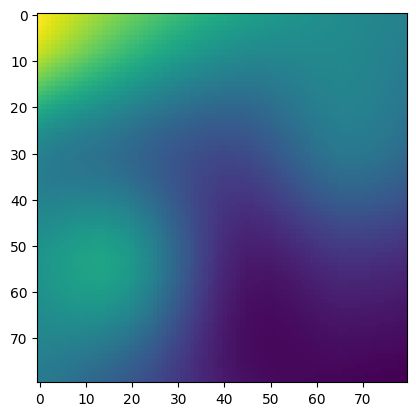

In [55]:
plt.imshow(data96["U10_MpS"]["TSTEP" == 0][0])

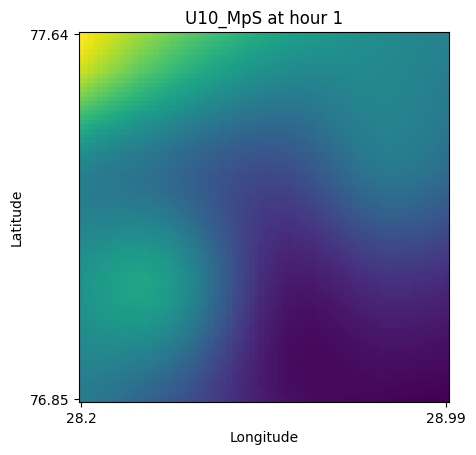

In [56]:
create_plot(data=data96, hour=1, var_name="U10_MpS")

In [57]:
data120_df = data120.to_dataframe().reset_index()

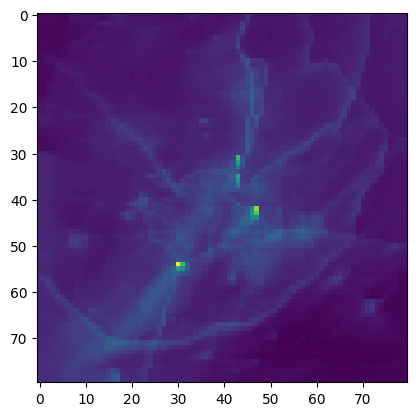

In [58]:
data120["P10"]["TSTEP" == 1][0]  # shape 80x80
plt.imshow(data120["P25"]["TSTEP" == 1][0])

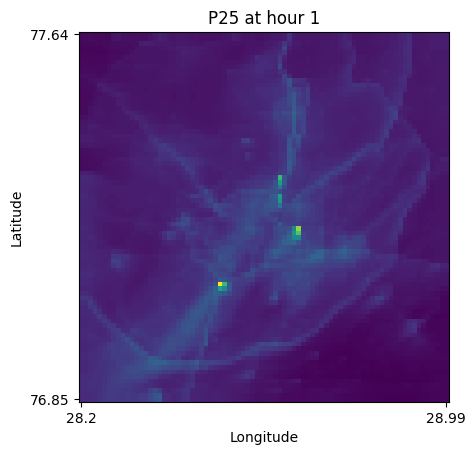

In [59]:
create_plot(data120, 1, "P25")

In [60]:
# Define the folder path where your files are located
folder_path = "/home/rishabh.mondal/archive/"

# Use glob to retrieve all netCDF files in the folder
file_pattern = "camx120*.nc"
files_120 = glob.glob(folder_path + file_pattern)
# files_120

file_pattern = "*96hours.nc"
files_96 = glob.glob(folder_path + file_pattern)
# files_96

In [61]:
print(len(files_120))
print(len(files_96))
files_120.sort()
print(files_120[0], files_120[-1])
files_96.sort()
print(files_96[0], files_96[-1])

70
69
/home/rishabh.mondal/archive/camx120hr_merged_20230717.nc /home/rishabh.mondal/archive/camx120hr_merged_20230924.nc
/home/rishabh.mondal/archive/camxmet2d.delhi.20230717.96hours.nc /home/rishabh.mondal/archive/camxmet2d.delhi.20230924.96hours.nc


In [62]:
files_120.remove("/home/rishabh.mondal/archive/camx120hr_merged_20230808.nc")
len(files_120)

69

In [63]:
def get_data(target_var_96_list, target_var_120_list):
    X = []
    y = []

    for target_var_96 in target_var_96_list:
        column = []
        for i in files_96:
            data_96 = xr.open_dataset(i)
            for j in range(0, 24):
                variable96 = data_96[target_var_96]["TSTEP" == j]
                column.append(variable96)
        column = np.array(column)
        # print(column.shape) # (69*24, 1, 80, 80)
        X.append(column)
    X = np.array(X)
    X = np.concatenate([X[i] for i in range(X.shape[0])], axis=1)
    print("X shape ", X.shape)
    for target_var_120 in target_var_120_list:
        column = []
        for i in files_120:
            data_120 = xr.open_dataset(i)
            for j in range(0, 24):
                variable120 = data_120[target_var_120]["TSTEP" == 24 + j]
                column.append(variable120)
        column = np.array(column)
        # print(column.shape) # (69*24, 1, 80, 80)
        y.append(column)
    y = np.array(y)
    y = np.concatenate([y[i] for i in range(y.shape[0])], axis=1)
    print("y shape", y.shape)
    return X, y

In [64]:
target_var_96_list = [
    "TSURF_K",
    "SNOWEW_M",
    "SNOWAGE_HR",
    "PRATE_MMpH",
    "CLOUD_OD",
    "U10_MpS",
    "V10_MpS",
    "T2_K",
    "SWSFC_WpM2",
    "SOLM_M3pM3",
    "CLDTOP_KM",
    "CAPE",
    "PBL_WRF_M",
    "PBL_YSU_M",
]  # ['U10_MpS', 'T2_K', 'V10_MpS']
target_var_120_list = ["P25", "P10"]
X, y = get_data(target_var_96_list, target_var_120_list)

X shape  (1656, 14, 80, 80)
y shape (1656, 2, 80, 80)


# Simple U-Net

In [65]:
from torch.nn import functional as F
import torch.nn as nn

In [66]:
import torch.nn.functional as F


class WUnet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(WUnet, self).__init__()

        # Encoder
        self.fc11 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.fc12 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.fc3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.fc6 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.fc9 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Middle
        self.middle = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        # Decoder
        self.fc10 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.fc11_dec = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.fc12_dec = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.fc13 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.fc14 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.fc15_dec = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.fc16 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.fc17 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.fc18_dec = nn.ConvTranspose2d(64, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        # Encoder
        # print(x.shape)
        x1 = F.relu(self.fc11(x))
        # print(x1.shape)
        x2 = F.relu(self.fc12(x1))
        # print(x2.shape)
        x3 = self.fc3(x2)
        # print(x3.shape)
        x4 = F.relu(self.fc4(x3))
        # print(x4.shape)
        x5 = F.relu(self.fc5(x4))
        # print(x5.shape)
        x6 = self.fc6(x5)
        # print(x6.shape)
        x7 = F.relu(self.fc7(x6))
        # print(x7.shape)

        x8 = F.relu(self.fc8(x7))
        # print(x8.shape)
        x9 = self.fc9(x8)
        # print(x9.shape)

        # Middle
        x_middle = F.relu(self.middle(x9))
        # print(x_middle.shape)
        # Decoder
        x10 = F.relu(self.fc10(x_middle))
        # print(x10.shape)
        x11 = F.relu(self.fc11_dec(x10))
        # print(x11.shape)
        x12 = F.relu(self.fc12_dec(x11))
        # print(x12.shape)
        x12_upsampled = F.interpolate(
            x12, size=x5.shape[2:], mode="bilinear", align_corners=False
        )
        # print(x12_upsampled.shape)
        x13 = F.relu(self.fc13(torch.cat([x5, x12_upsampled], dim=1)))
        # print(x13.shape)
        x14 = F.relu(self.fc14(x13))
        # print(x14.shape)
        x15 = F.relu(self.fc15_dec(x14))
        # print(x15.shape)
        x16 = F.relu(self.fc16(torch.cat([x2, x15], dim=1)))
        # print(x16.shape)
        x17 = F.relu(self.fc17(x16))
        # print(x17.shape)
        x18 = F.relu(self.fc18_dec(x17))
        # print(x18.shape)
        return x18


in_channels = 1
out_channels = 1

unet = WUnet(in_channels, out_channels)

# Example usage:
input_weather_data = torch.randn(1, in_channels, 80, 80)
# print(input_weather_data)
output_weather_prediction = unet(input_weather_data)

In [29]:
# print model summary
from torchsummary import summary

device = torch.device("cuda:0")
unet = unet.to(device)
input_tensor = input_weather_data.to(device)
summary(unet, (1, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]             640
            Conv2d-2           [-1, 64, 80, 80]          36,928
         MaxPool2d-3           [-1, 64, 40, 40]               0
            Conv2d-4          [-1, 128, 40, 40]          73,856
            Conv2d-5          [-1, 128, 40, 40]         147,584
         MaxPool2d-6          [-1, 128, 20, 20]               0
            Conv2d-7          [-1, 256, 20, 20]         295,168
            Conv2d-8          [-1, 256, 20, 20]         590,080
         MaxPool2d-9          [-1, 256, 10, 10]               0
           Conv2d-10          [-1, 512, 10, 10]       1,180,160
           Conv2d-11          [-1, 256, 10, 10]       1,179,904
           Conv2d-12          [-1, 256, 10, 10]         590,080
  ConvTranspose2d-13          [-1, 128, 20, 20]         131,200
           Conv2d-14          [-1, 128,

In [67]:
import torch.onnx

# dummy_input = torch.randn(1, 3, 224, 224)
input_weather_data = torch.randn(1, 1, 80, 80)

# Export the model to ONNX
onnx_file_path = "your_model.onnx"
torch.onnx.export(unet, input_weather_data, onnx_file_path, verbose=False)
print("Model exported to ONNX successfully.")

Model exported to ONNX successfully.


In [69]:
import netron

netron.start(onnx_file_path)

Serving 'your_model.onnx' at http://localhost:8080


('localhost', 8080)

In [70]:
class CustomDataset(data.Dataset):
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_sample = torch.Tensor(self.input_data[index])
        output_sample = torch.Tensor(self.output_data[index])
        return input_sample, output_sample

In [71]:
X.shape, y.shape

((1656, 14, 80, 80), (1656, 2, 80, 80))

In [72]:
from sklearn.model_selection import train_test_split

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape

((1324, 14, 80, 80), (332, 14, 80, 80), (1324, 2, 80, 80), (332, 2, 80, 80))

In [73]:
test_days = 5  # 5 days as test data
X_train_all = X[: -24 * test_days]
X_test_all = X[-24 * test_days :]
y_train_all = y[: -24 * test_days]
y_test_all = y[-24 * test_days :]
X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape

((1536, 14, 80, 80), (120, 14, 80, 80), (1536, 2, 80, 80), (120, 2, 80, 80))

In [ ]:
test_loss_list_p_25 = []
y_channel = 0
for x_channel in range(X.shape[1]):
    ####################### Selecting the channel #######################
    print("x channel name :", target_var_96_list[x_channel])
    X_train = X_train_all[:, x_channel, :, :]
    X_test = X_test_all[:, x_channel, :, :]
    y_train = y_train_all[:, y_channel, :, :]
    y_test = y_test_all[:, y_channel, :, :]
    ####################### Creating data loader #######################
    train_dataset = CustomDataset(X_train, y_train)
    batch_size = 32
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    print("train_loader shape :", len(train_loader))

    test_dataset = CustomDataset(X_test, y_test)
    batch_size = 32
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )
    print("test_loader shape :", len(test_loader))

    ####################### Training #######################
    from tqdm import tqdm
    import torch.optim as optim

    model = WUnet(in_channels=1, out_channels=1)
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses = []
    epochs = 40
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.unsqueeze(1)
            targets = targets.unsqueeze(1)
            inputs = inputs.to(device)
            targets = targets.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss = loss.item()

        average_loss = total_loss / len(train_loader)
        losses.append(average_loss)
        if epoch % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Loss: {average_loss:.4f}")

    print("Finished Training")

    ####################### Testing #######################
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.unsqueeze(1)
            targets = targets.unsqueeze(1)
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    average_test_loss = test_loss / len(test_loader)
    test_loss_list_p_25.append(average_test_loss)
    print(f"Average Test Loss: {average_test_loss:.4f}")
    print("Finished Testing")

    ####################### Plot the train losses #######################
    plt.plot(range(1, epochs + 1), losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()